# Normalization and batch correction

## Settings

In [1]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/ext_ana/processed'
test = 'all'

In [2]:
# choose normalization method. If None, two normalization methods will be 
# performed and visualized with pca plot
norm_method='tfidf'  # can be 'tfidf' or 'total'
# remove_pc1: if True, the first PC is removed from TFIDF-LSI normalization before calculating neighbors, 
# since first component correlates with number of features
log_normalize=True

# Highly Variable Features options 
min_cells = 5 # This one is mandatory
max_cells = None

# UMAP related settings 
metacol = 'Sample'

# batch correction: If True, several batch correction methods will be performed,
# you can choose the best one after
batch_column = "Sample"
perform_batch_correction = True
batch_methods = ["bbknn", "harmony"] # "mnn", "scanorama"
threads = 8

# save figures
save_figs = False

## Loading packages and setup

In [3]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
import sctoolbox.plotting as pl
from sctoolbox.atac_utils import *
from sctoolbox.analyser import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
#from episcanpy.preprocessing import _decomposition
import numpy as np

## Setup path handling object 

In [4]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [5]:
# probably updated in future
qc_output = tree.qc_anndata  # path to qc_adata should be here
adata = epi.read_h5ad(qc_output)
adata

AnnData object with n_obs × n_vars = 53913 × 145907
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_fragments_in_promoters', 'n_total_fragments', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'anno

## Find highly variable features

In [6]:
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,annotation_query,region_length,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness
chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,NaN,374,274,0.006437,0.006416,99.658852,517.0,6.249975,178,274.0
chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,protein_coding_promoter,477,7932,0.226976,0.204552,90.124133,18230.0,9.810879,3944,7932.0
chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,protein_coding_promoter,285,1788,0.045221,0.044228,97.773821,3632.0,8.197814,967,1788.0
chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,protein_coding_internal,256,289,0.006898,0.006874,99.640176,554.0,6.318968,128,289.0
chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,protein_coding_promoter,233,1040,0.024017,0.023733,98.705131,1929.0,7.565275,492,1040.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,protein_coding_promoter,266,2128,0.049890,0.048685,97.350499,4007.0,8.296047,1044,2128.0
chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,protein_coding_distal,247,521,0.012849,0.012767,99.351320,1032.0,6.940222,287,521.0
chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,protein_coding_distal,402,507,0.012538,0.012460,99.368751,1007.0,6.915723,273,507.0
chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,any_gene_distal,221,229,0.005416,0.005401,99.714880,435.0,6.077642,158,229.0


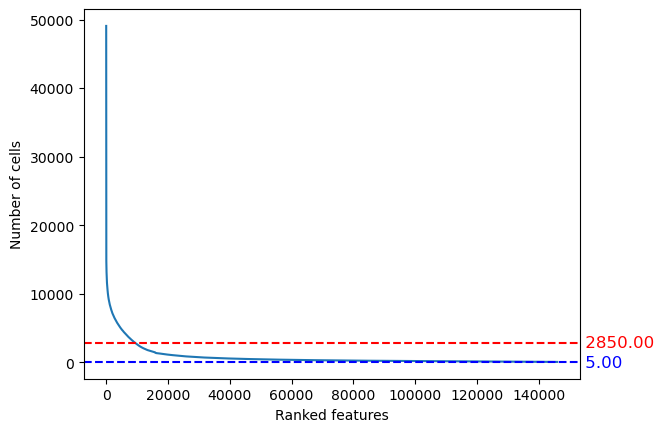

In [7]:
# update number of cells per feature
adata = analyser.calculate_qc_metrics(adata, var_type='features')
# get highly variable features
atac.get_variable_features(adata, max_cells, min_cells)

In [8]:
#Number of variable genes selected
adata.var["highly_variable"].sum()

136555

In [9]:
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,region_length,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,highly_variable
chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,374,178,0.003302,0.003296,99.669838,178.0,5.187386,178,274.0,True
chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,477,3944,0.073155,0.070603,92.684510,3944.0,8.280204,3944,7932.0,False
chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,285,967,0.017936,0.017777,98.206370,967.0,6.875232,967,1788.0,True
chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,256,128,0.002374,0.002371,99.762580,128.0,4.859812,128,289.0,True
chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,233,492,0.009126,0.009084,99.087419,492.0,6.200509,492,1040.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,266,1044,0.019365,0.019179,98.063547,1044.0,6.951772,1044,2128.0,True
chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,247,287,0.005323,0.005309,99.467661,287.0,5.662961,287,521.0,True
chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,402,273,0.005064,0.005051,99.493629,273.0,5.613128,273,507.0,True
chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,221,158,0.002931,0.002926,99.706935,158.0,5.068904,158,229.0,True


In [10]:
reset_cutoffs_dec = input('Do you want to change the cutoffs again? answer with yes or no: ')

Do you want to change the cutoffs again? answer with yes or no: no


In [11]:
if reset_cutoffs_dec.lower() == 'yes':
    min_cells = input('Enter the minimal number of cells per feature?: ')
    max_cells = input('Enter the maximum number of cells per feature?: ')
    min_cells = int(min_cells)
    max_cells = int(max_cells)
    adata.var["highly_variable"] = (adata.var['n_cells_by_counts'] <= max_cells) & (adata.var['n_cells_by_counts'] >= min_cells)
    print('Number of highly variable features: ' + str(adata.var["highly_variable"].sum()))

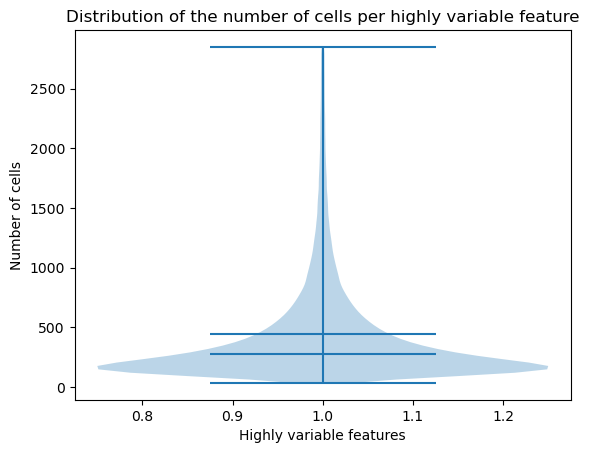

In [12]:
violin_HVF_distribution(adata)

## Normalization

In [13]:
# Consider using parts of sctoolbox.analyser

In [14]:
if norm_method == 'tfidf':
    print('Performing TFIDF and LSI...')
    atac.tfidf(adata)
    atac.lsi(adata)
    print('Done')
if norm_method == 'total':
    print('Performing total and log1p normalization...')
    sc.pp.normalize_total(adata)
    adata.layers['normalised'] = adata.X.copy()
    if log_normalize:
        epi.pp.log1p(adata)
    print('Done')
if not norm_method:
    adata_tfidf, adata_total = atac.atac_norm(adata)

Performing TFIDF and LSI...
Done


In [15]:
if not norm_method:
    user_norm = input('Choose a normalization method (total or tfidf): ')
    if user_norm == 'total':
        adata = adata_total
    elif user_norm == 'tfidf':
        adata = adata_tfidf
else:
    user_norm = None
    
display(adata)

AnnData object with n_obs × n_vars = 53913 × 145907
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_fragments_in_promoters', 'n_total_fragments', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'anno

## PCA

In [16]:
print('Performing PCA')
sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)
print('Done')

Performing PCA
Done


### Plot PCA

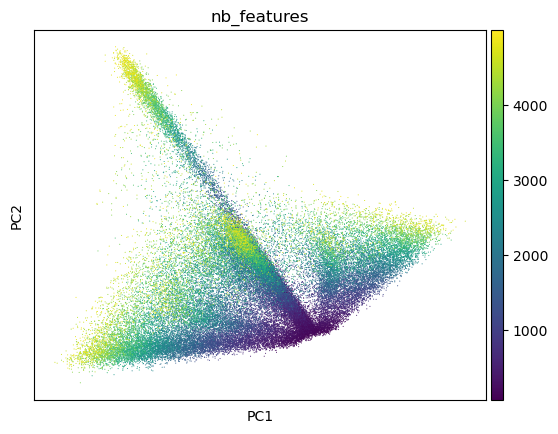

In [17]:
if norm_method == 'tfidf' or user_norm == 'tfidf':
    # Change to module
    if save_figs:
        epi.pl.pca(adata, color=['nb_features'], show=False)
        #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
        plt.show()
    else:
        epi.pl.pca(adata, color=['nb_features'])
        
elif norm_method == 'total':
    if save_figs:
        epi.pl.pca_overview(adata, color=['nb_features'], show=False)
        #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
        plt.show()
    else:
        epi.pl.pca_overview(adata, color=['nb_features'])

## Calc Neighbours

In [18]:
if norm_method:
    if norm_method == 'tfidf':
        print('Calculating neighbors')
        sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, method='umap', metric='euclidean')
    else:
        print('Calculating neighbors')
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, method='umap', metric='euclidean')
    print('Done')

Calculating neighbors
Done


## UMAP

Computing UMAPs:   0%|          | 0/8 [00:01<?, ?it/s]

Plotting umap for spread=2.0 and dist=0.1 (1/8)
Plotting umap for spread=2.0 and dist=0.2 (2/8)
Plotting umap for spread=2.0 and dist=0.3 (3/8)
Plotting umap for spread=2.0 and dist=0.4 (4/8)
Plotting umap for spread=2.5 and dist=0.1 (5/8)
Plotting umap for spread=2.5 and dist=0.2 (6/8)
Plotting umap for spread=2.5 and dist=0.3 (7/8)
Plotting umap for spread=2.5 and dist=0.4 (8/8)


array([[<AxesSubplot:title={'center':'min_dist: 0.1'}, ylabel='spread: 2.0'>,
        <AxesSubplot:title={'center':'min_dist: 0.2'}>,
        <AxesSubplot:title={'center':'min_dist: 0.3'}>,
        <AxesSubplot:title={'center':'min_dist: 0.4'}>],
       [<AxesSubplot:ylabel='spread: 2.5'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

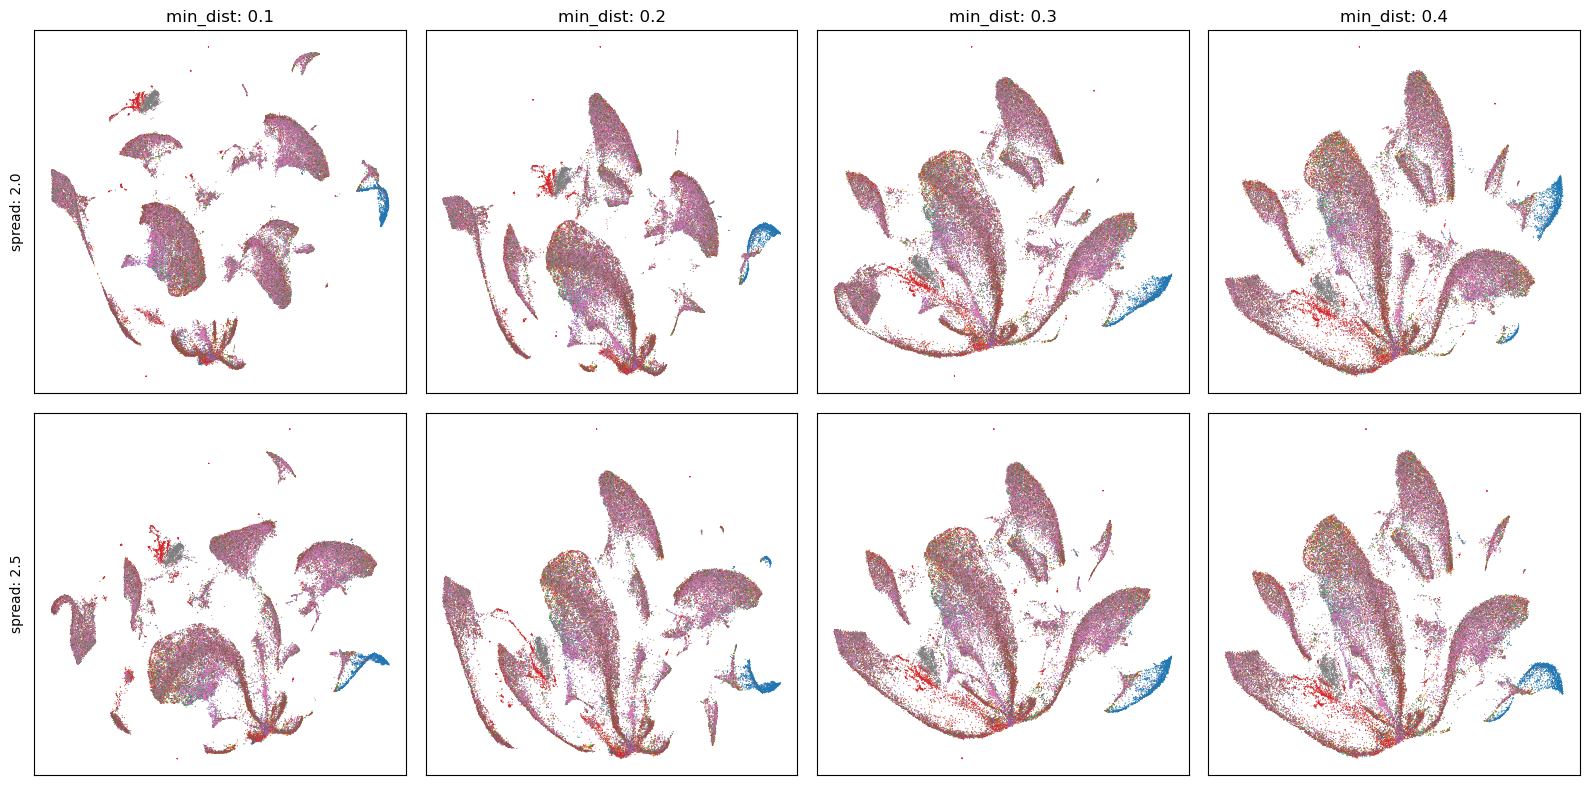

In [19]:
pl.search_umap_parameters(adata, 
                       dist_range=(0.1, 0.4, 0.1), 
                       spread_range=(2.0, 3.0, 0.5), 
                       metacol=metacol, 
                       n_components=2, 
                       verbose=True, 
                       threads=4, 
                       save=None)

## Batch Correction

In [20]:
adata.obs[batch_column] = adata.obs[batch_column].astype("category") #ensure that batch column is a category

In [21]:
if perform_batch_correction:
    batch_corrections = analyser.wrap_corrections(adata, 
                                              batch_key=batch_column,
                                              methods=batch_methods)
else:
    batch_corrections = {"uncorrected": adata}

Running batch correction with 'bbknn'...
Running batch correction with 'harmony'...
Finished batch correction(s)!


In [22]:
#Run standard umap for all adatas
analyser.wrap_umap(batch_corrections.values(), threads=threads)

Computing UMAPs :   0%|          | 0/3 [00:01<?, ?it/s]

In [23]:
# Should preliminary clustering be performed?
do_clustering = True #True or False

In [24]:
#Perform additional clustering if it was chosen
color_by = []
if do_clustering:
    for adata in batch_corrections.values():
        sc.tl.leiden(adata, 0.1)
    color_by.append("leiden")

In [25]:
# Calculate LISI scores for batch
analyser.wrap_batch_evaluation(batch_corrections, batch_key=batch_column, threads=threads, inplace=True)

Calculating LISI scores:   0%|          | 0/6 [00:00<?, ?it/s]

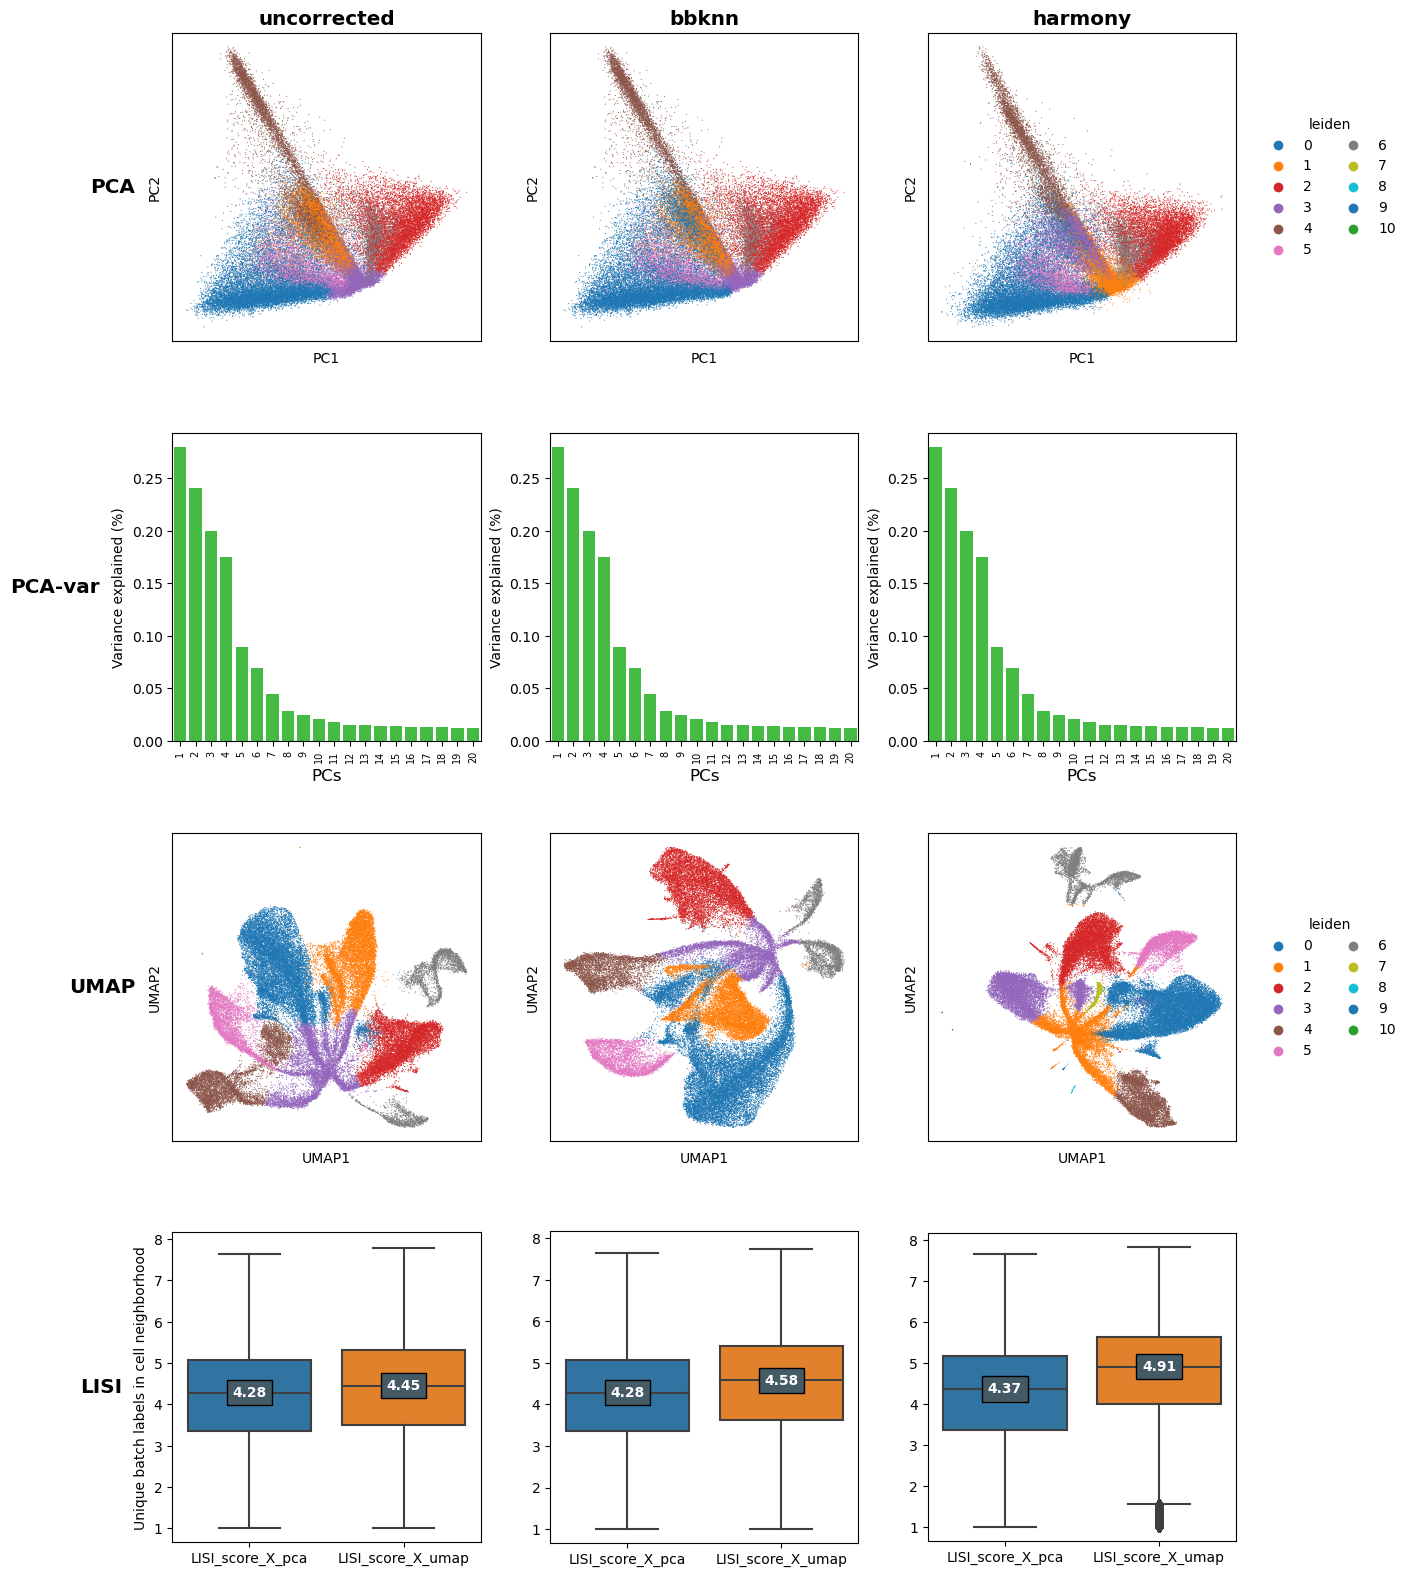

In [26]:
#Plot the overview of batch correction methods
_ = pl.anndata_overview(batch_corrections, color_by=color_by, 
                       output=tree.norm_correction_plots + "batch_correction_overview.pdf")

In [27]:
#Choose an anndata object to proceed
batch_name = input('Choose an anndata object to proceed. Type the name of the batch correction or uncorrected: ')
try:
    adata_corrected = batch_corrections[batch_name]
except:
    adata_corrected = batch_corrections['uncorrected']

Choose an anndata object to proceed. Type the name of the batch correction or uncorrected: harmony


## save anndata

In [29]:
adata_output = tree.norm_correction_anndata
adata_corrected.write(filename=adata_output)

In [31]:
import os
import shutil
repo_path = os.getcwd()
notebook_name = '03_normalization_batch_correction.ipynb'
notebook_path = os.path.join(repo_path, notebook_name)
notebook_copy = os.path.join(tree.norm_correction_dir , notebook_name)
shutil.copyfile(notebook_path, notebook_copy)

'/mnt/workspace/jdetlef/ext_ana/processed/all/norm_correction/03_normalization_batch_correction.ipynb'